In [1]:
import networkx as nx
import tsplib95 as tsp
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt

# Algorithms

## Branch and Bound

In [2]:
problem = tsp.load('test10.tsp')

In [3]:
# Implements the branch and bound algorithm

class Node:
    def __init__(self, bound, path, edges, cost):
        self.bound = bound
        self.path = path
        self.edges = edges
        self.cost = cost
    
    def __lt__(self, other):
        if len(self.path) == len(other.path): #longer paths mean we are closer to the complete solution
            return self.cost < other.cost #prioritize lower costs
        else:
            return len(self.path) > len(other.path)
    
def findSmallestEdges(problem, node):
    min1 = float('inf')
    min2 = float('inf')
    for other_node in problem.get_nodes():
        if other_node != node:
            weight = problem.get_weight(node, other_node)
            if weight < min1:
                min2 = min1
                min1 = weight
            elif weight < min2:
                min2 = weight
    return min1, min2

def computeFirstBound(problem):
    bound = 0
    num_nodes = problem.dimension
    initialBoundEdges = np.zeros((num_nodes + 1, 2))

    for i in range(1, num_nodes + 1):
        min1, min2 = findSmallestEdges(problem, i)
        initialBoundEdges[i][0] = min1
        initialBoundEdges[i][1] = min2
        bound += min1 + min2

    return bound / 2, initialBoundEdges

def computeNodeBound(problem, path, edges, bound):
    num_nodes = problem.dimension + 1
    changedEdges = np.zeros(num_nodes, dtype=int)
    newEdges = np.array(edges)

    # Get the weight of the most recently added edge in the path
    edgeWeight = problem.get_weight(path[-2], path[-1])
    
    # Double the current bound to adjust for calculations
    sum = bound * 2

    # Update for the second-to-last node in the path
    if newEdges[path[-2]][0] != edgeWeight:
        if changedEdges[path[-2]] == 0:
            sum -= newEdges[path[-2]][1]
            sum += edgeWeight
        else:
            sum -= newEdges[path[-2]][0]
            sum += edgeWeight
        changedEdges[path[-2]] += 1

    # Update for the last node in the path
    if newEdges[path[-1]][0] != edgeWeight:
        if changedEdges[path[-1]] == 0:
            sum -= newEdges[path[-1]][1]
            sum += edgeWeight
        else:
            sum -= newEdges[path[-1]][0]
            sum += edgeWeight
        changedEdges[path[-1]] += 1

    # Return the updated bound and the updated edges array
    return sum / 2, newEdges

def branchAndBoundTSP(problem):
    initialBound, initialBoundEdges = computeFirstBound(problem)
    root = Node(initialBound, [1], initialBoundEdges, 0)
    pq = PriorityQueue()
    pq.put(root)
    best = float('inf')
    best_solution = []
    num_nodes = problem.dimension

    while not pq.empty():
        node = pq.get()
        level = len(node.path)

        # Check if a complete solution is found
        if level == num_nodes:
            if node.cost < best:
                best = node.cost
                best_solution = node.path 
        else:
            # Explore further only if the current bound is less than the best known cost
            if node.bound < best:
                for k in range(1, num_nodes + 1):
                    if k not in node.path:
                        new_solution = node.path + [k]
                        edgeWeight = problem.get_weight(node.path[-1], k)
                        newBound, newEdges = computeNodeBound(problem, new_solution, node.edges, node.bound)

                        # Check if the new node is promising
                        if newBound < best:
                            new_cost = node.cost + edgeWeight
                            newNode = Node(newBound, new_solution, newEdges, new_cost)
                            pq.put(newNode)

    best = best + problem.get_weight(best_solution[-1], 1) #add the weight of the last edge to the first node
    best_solution.append(1)

    return best, best_solution


In [4]:
best_cost, best_solution = branchAndBoundTSP(problem)
print("Best cost:", best_cost)
print("Best solution:", best_solution)

Best cost: 2826
Best solution: [1, 5, 6, 4, 10, 9, 8, 3, 7, 2, 1]


## Twice-around-the-tree

In [5]:
def findPathWeight(problem, path):
    weight = 0
    for i in range(len(path) - 1):
        weight += problem.get_weight(path[i], path[i + 1])
    return weight

def twiceAroundTheTreeTSP(problem):
    A = problem.get_graph()
    MST = nx.minimum_spanning_tree(A)
    path = list(nx.dfs_preorder_nodes(MST, 1))  # Assuming the nodes start from 1
    path.append(path[0])
    weight = findPathWeight(problem, path)
    return weight, path

In [6]:
best_cost, best_solution = twiceAroundTheTreeTSP(problem)
print("Best cost:", best_cost)
print("Best solution:", best_solution)

Best cost: 3439
Best solution: [1, 3, 8, 10, 9, 7, 2, 5, 6, 4, 1]


## Christofides Algorithm

In [7]:
def findShortcutPath(graph):
    path = list(nx.eulerian_circuit(graph, 1))
    path = [x[0] for x in path]

    # Remove duplicates
    shortcutPath = list(dict.fromkeys(path))
    
    return shortcutPath + [shortcutPath[0]]

def christofidesTSP(problem):
    graph = problem.get_graph()

    MST = nx.minimum_spanning_tree(graph)
    degrees = nx.degree(MST)
    odd_nodes = [node for node, degree in degrees if degree % 2 == 1]
    odd_nodes_subgraph = graph.subgraph(odd_nodes)
    matching = list(nx.min_weight_matching(odd_nodes_subgraph, maxcardinality=True))    

    MST_multi_graph = nx.MultiGraph(MST)
    for node1, node2 in matching:
        MST_multi_graph.add_edge(node1, node2, weight=problem.get_weight(node1, node2))

    path = findShortcutPath(MST_multi_graph)
    weight = findPathWeight(problem, path)

    return weight, path


In [8]:
best_cost, best_solution = christofidesTSP(problem)
print("Best cost:", best_cost)
print("Best solution:", best_solution)

Best cost: 2900
Best solution: [1, 5, 6, 4, 9, 10, 8, 3, 7, 2, 1]


In [9]:
# open the results file as a dataframe
import pandas as pd
df = pd.read_csv('test_results_table.csv')
df.head()  

,Instância,Algoritmo,Nós,Limiar,Resultado,Qualidade,Tempo de execução(s),Memória(bytes)
0,eil51,Twice Around the Tree,51,426.0,584,1.370892,0.036392,617165
1,eil51,Christofides,51,426.0,462,1.084507,0.062512,747445
2,berlin52,Twice Around the Tree,52,7542.0,10114,1.341024,0.038016,518952
3,berlin52,Christofides,52,7542.0,8591,1.139088,0.062031,721336
4,st70,Twice Around the Tree,70,675.0,888,1.315556,0.072637,850420


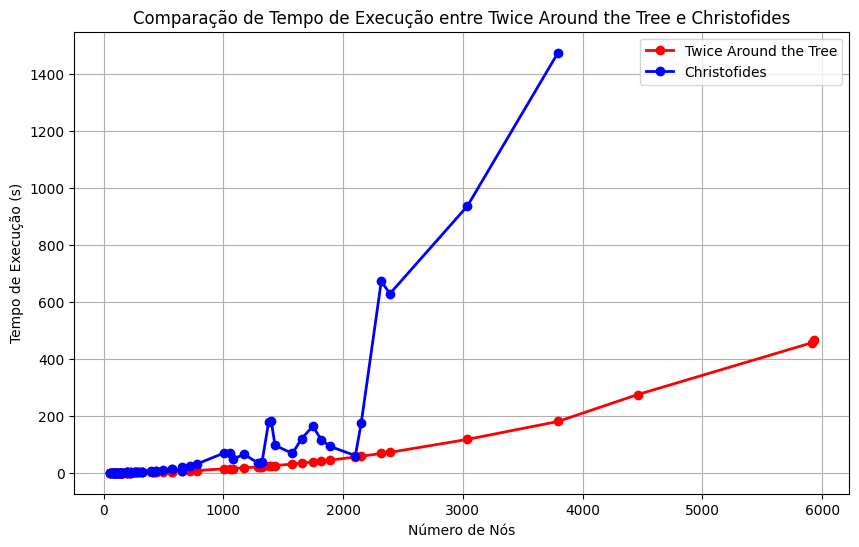

In [10]:
# Filtrar os dados para Christofides e Twice Around the Tree
twice_around_the_tree = df[df['Algoritmo'] == 'Twice Around the Tree']
christofides = df[df['Algoritmo'] == 'Christofides']

# Criar gráfico de dispersão com linhas
plt.figure(figsize=(10, 6))
plt.plot(twice_around_the_tree['Nós'], twice_around_the_tree['Tempo de execução(s)'], 'ro-', label='Twice Around the Tree', linewidth=2)
plt.plot(christofides['Nós'], christofides['Tempo de execução(s)'], 'bo-', label='Christofides', linewidth=2)

# Adicionar rótulos e título
plt.xlabel('Número de Nós')
plt.ylabel('Tempo de Execução (s)')
plt.title('Comparação de Tempo de Execução entre Twice Around the Tree e Christofides')
plt.legend()

# Exibir o gráfico
plt.grid(True)  # Adiciona uma grade para facilitar a leitura dos valores
plt.show()


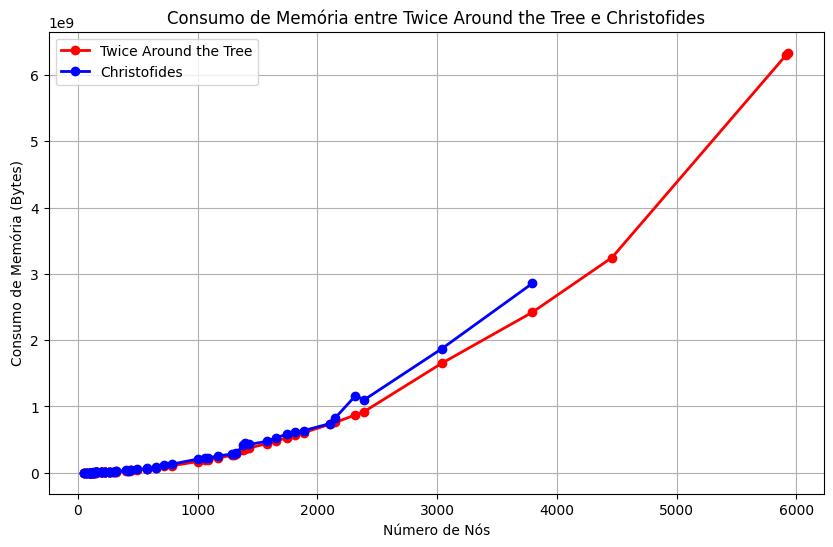

In [11]:
# Criar gráfico de dispersão com linhas
plt.figure(figsize=(10, 6))
plt.plot(twice_around_the_tree['Nós'], twice_around_the_tree['Memória(bytes)'], 'ro-', label='Twice Around the Tree', linewidth=2)
plt.plot(christofides['Nós'], christofides['Memória(bytes)'], 'bo-', label='Christofides', linewidth=2)

# Adicionar rótulos e título
plt.xlabel('Número de Nós')
plt.ylabel('Consumo de Memória (Bytes)')
plt.title('Consumo de Memória entre Twice Around the Tree e Christofides')
plt.legend()

# Exibir o gráfico
plt.grid(True)  # Adiciona uma grade para facilitar a leitura dos valores
plt.show()

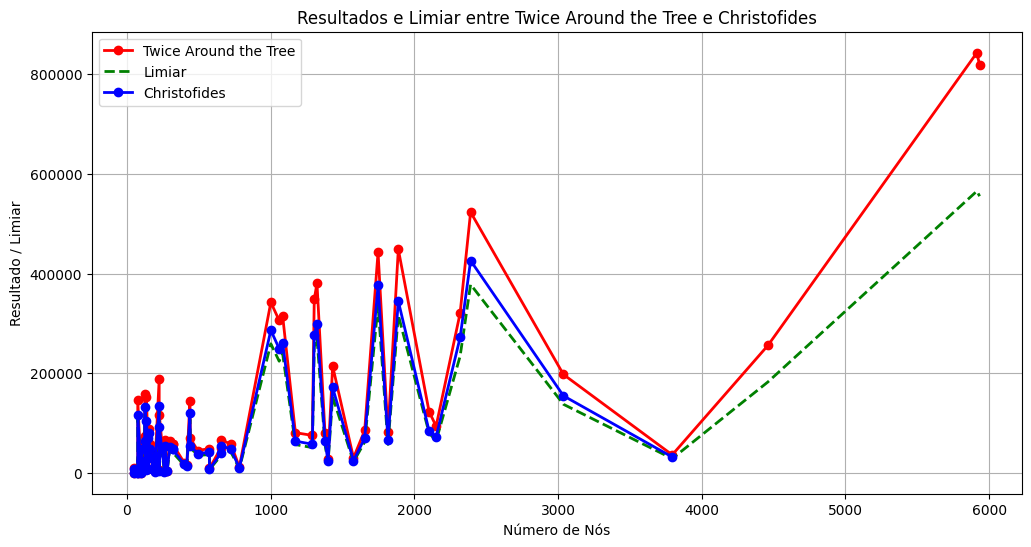

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(twice_around_the_tree['Nós'], twice_around_the_tree['Resultado'], 'ro-', label='Twice Around the Tree', linewidth=2)
plt.plot(twice_around_the_tree['Nós'], twice_around_the_tree['Limiar'], 'g--', label='Limiar', linewidth=2)

# Criar gráfico de dispersão com linhas para Christofides
plt.plot(christofides['Nós'], christofides['Resultado'], 'bo-', label='Christofides', linewidth=2)


# Adicionar rótulos e título
plt.xlabel('Número de Nós')
plt.ylabel('Resultado / Limiar')
plt.title('Resultados e Limiar entre Twice Around the Tree e Christofides')
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [13]:
def generate_latex_table_from_file(file_path):
    try:
        # Read data from the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Start building the LaTeX table
        latex_table = [
        "\\begin{longtable}{|c|c|c|c|c|c|c|c|}",
        "\\hline",
        "\\textbf{Instância} & \\textbf{Algoritmo} & \\textbf{Nós} & \\textbf{Limiar} & \\textbf{Resultado} & \\textbf{Qualidade} & \\textbf{Tempo(s)} & \\textbf{Bytes} \\\\",
        "\\hline",
        "\\endfirsthead",  # Add header on subsequent pages
        "\\multicolumn{8}{c}%",
        "{{\\tablename\\ \\thetable{} -- Continuação}} \\\\",
        "\\hline",
        "\\textbf{Instância} & \\textbf{Algoritmo} & \\textbf{Nós} & \\textbf{Limiar} & \\textbf{Resultado} & \\textbf{Qualidade} & \\textbf{Tempo(s)} & \\textbf{Bytes} \\\\",
        "\\hline",
        "\\endhead",  # Header for subsequent pages
        "\\hline",
        "\\endfoot",
        "\\hline"
        ]

        # Process each line of the file and add to the table
        for line in lines[1:]:  # Skip the header line
            # Remove extra spaces and newlines
            data = line.strip().split(',')
            # Check if the line has the correct number of columns
            if len(data) == 8:
                # Round the quality to two decimal places
                # Replace '%' with 'x'
                data[5] = f"{float(data[5].strip('%')):.2f}x"
                # Replace 'Twice Around the Tree' with 'TATT'
                data[1] = 'TATT' if data[1] == 'Twice Around the Tree' else data[1]
                # Replace 'Christofides' with 'CRIS'
                data[1] = 'CHRI' if data[1] == 'Christofides' else data[1]
                # Truncate the execution time to two decimal places
                data[6] = f"{float(data[6]):.2f}"
                # Add the formatted line to the table
                latex_table.append(" & ".join(data) + " \\\\")
            else:
                print(f"Invalid or insufficient data in line: {line}")

        # Finish the table
        latex_table.extend([
            "\\hline",
            "\\caption{Resultados experimentais: Twice-Around-The-Tree (TATT) e Christofides (CHRI)}",
            "\\label{tab:algorithms_comparison}",
            "\\end{longtable}"
        ])

        return "\n".join(latex_table)

    except FileNotFoundError:
        return "File not found."

# Caminho do arquivo de dados
file_path = "test_results_table.csv"  # Substitua pelo caminho correto do seu arquivo CSV

# Gerar a tabela em LaTeX
latex_table_content = generate_latex_table_from_file(file_path)
print(latex_table_content)


\begin{longtable}{|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instância} & \textbf{Algoritmo} & \textbf{Nós} & \textbf{Limiar} & \textbf{Resultado} & \textbf{Qualidade} & \textbf{Tempo(s)} & \textbf{Bytes} \\
\hline
\endfirsthead
\multicolumn{8}{c}%
{{\tablename\ \thetable{} -- Continuação}} \\
\hline
\textbf{Instância} & \textbf{Algoritmo} & \textbf{Nós} & \textbf{Limiar} & \textbf{Resultado} & \textbf{Qualidade} & \textbf{Tempo(s)} & \textbf{Bytes} \\
\hline
\endhead
\hline
\endfoot
\hline
eil51 & TATT & 51 & 426 & 584 & 1.37x & 0.04 & 617165 \\
eil51 & CHRI & 51 & 426 & 462 & 1.08x & 0.06 & 747445 \\
berlin52 & TATT & 52 & 7542 & 10114 & 1.34x & 0.04 & 518952 \\
berlin52 & CHRI & 52 & 7542 & 8591 & 1.14x & 0.06 & 721336 \\
st70 & TATT & 70 & 675 & 888 & 1.32x & 0.07 & 850420 \\
st70 & CHRI & 70 & 675 & 770 & 1.14x & 0.09 & 1145938 \\
eil76 & TATT & 76 & 538 & 696 & 1.29x & 0.07 & 941108 \\
eil76 & CHRI & 76 & 538 & 608 & 1.13x & 0.10 & 1358677 \\
pr76 & TATT & 76 & 108159 & 145336 & 1.34x & 0